In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Models import *
from sklearn.metrics import confusion_matrix

# DATA

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


data_train =pd.read_csv("data/train_agnews.csv")
X = data_train.iloc[:,2] + data_train.iloc[:,1]
y = data_train.iloc[:,0].apply(lambda x: x-1) 

data_test =pd.read_csv("data/test_agnews.csv")
X_test = data_test.iloc[:,2] + data_test.iloc[:,1]
y_test = data_test.iloc[:,0].apply(lambda x: x-1) 

X_train, X_val, y_train, y_val = train_test_split(X, y)


lengths = [len(a.split()) for a in X_train]

# Sentence length distribution

(array([2.9440e+03, 4.6371e+04, 3.7250e+04, 2.7410e+03, 4.5500e+02,
        1.4100e+02, 5.8000e+01, 2.6000e+01, 1.2000e+01, 2.0000e+00]),
 array([  3. ,  20.3,  37.6,  54.9,  72.2,  89.5, 106.8, 124.1, 141.4,
        158.7, 176. ]),
 <BarContainer object of 10 artists>)

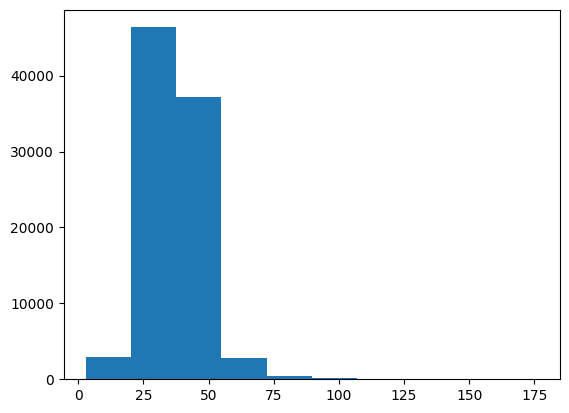

In [3]:
plt.hist(lengths)

# Tokenization

In [4]:
max_len = 80 
vocabulary_size = 10000 # random value
embed_size = 32    # random value 

tok = Tokenizer(num_words=vocabulary_size)
tok.fit_on_texts(X_train.values)


# Token 
X_train = tok.texts_to_sequences(X_train)
X_val = tok.texts_to_sequences(X_val)
X_test = tok.texts_to_sequences(X_test)

# Now we need to pad all the sequences based on the max value 

X_train = pad_sequences(X_train, maxlen=max_len)
X_val = pad_sequences(X_val, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# Visualisation of some sentences

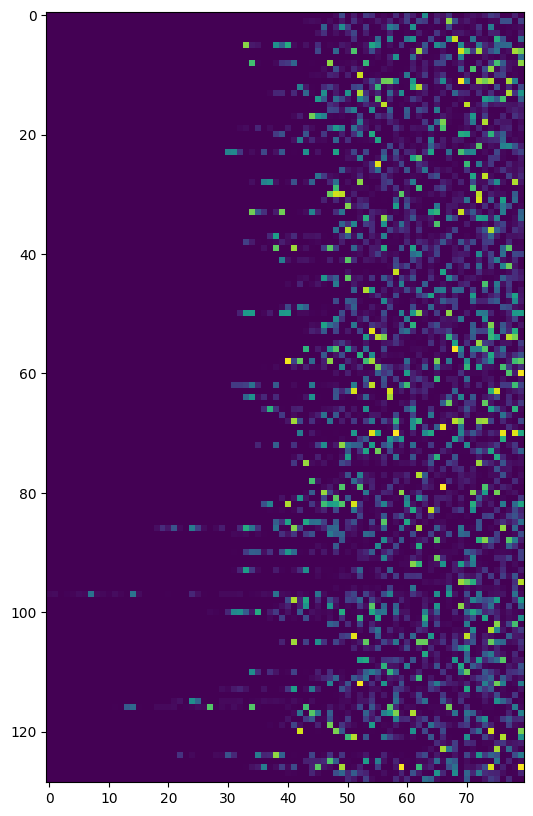

In [5]:
plt.figure(figsize=(10,10))
i=35
plt.imshow(X_train[129*i:129*(i+1)])


# Experiments

In [6]:
def experiment(train,val,max_len = 80, vocabulary_size = 10000, embed_size = 32,epochs=10):
    X_train,y_train = train
    X_val,y_val = val
    models = {}
    for model_fun,name in zip([get_small, get_medium],['small', 'medium']):
        for optimizer in ['adam', 'rmsprop']:
            for binary in [False, True]:
                model = model_fun(optimizer=optimizer,binary=binary,max_len=max_len,vocabulary_size=vocabulary_size,embed_size=embed_size)
                model.fit(X_train,y_train,batch_size=256,validation_data=(X_val,y_val),epochs=epochs,verbose=0)
                b = "binary" if binary else "standard"
                models[name+"_"+b+"_"+optimizer] = model

    for binary in [False, True]:
        model = get_large(optimizer='adam',binary=binary,max_len=max_len,vocabulary_size=vocabulary_size,embed_size=embed_size)
        model.fit(X_train,y_train,batch_size=256,validation_data=(X_val,y_val),epochs=epochs,verbose=0)
        b = "binary" if binary else "standard"
        models['large'+"_"+b+"_adam"] = model
                
    for optimizer in ['adam', 'rmsprop']:
        for lr in [0.01,0.001,0.0001]:
            model = get_small(optimizer=optimizer,lr=lr,binary=True,max_len=max_len,vocabulary_size=vocabulary_size,embed_size=embed_size)
            model.fit(X_train,y_train,batch_size=256,validation_data=(X_val,y_val),epochs=epochs,verbose=0)
            models["small_binary_lr="+str(lr)+"_"+optimizer] = model

    for optimizer in ['adam', 'rmsprop']:
        for bs in [32,128,256]:
            model = get_small(optimizer=optimizer,binary=True,max_len=max_len,vocabulary_size=vocabulary_size,embed_size=embed_size)
            model.fit(X_train,y_train,batch_size=bs,validation_data=(X_val,y_val),epochs=epochs,verbose=0)
            models["small_binary_bs="+str(bs)+"_"+optimizer] = model
    return models

In [7]:
def plot_diffrent_sizes(models):
    for model in ['small', 'medium', 'large']:
        for binary in ["binary","standard"]:
            for optimizer in ['adam', 'rmsprop']:
                if model=='large' and optimizer=='rmsprop':
                    continue
                plt.plot(models[model+"_"+binary+"_"+optimizer].history.history["val_accuracy"], label=model+"_"+binary+"_"+optimizer)
        plt.title("Validation accuracy")
        plt.legend()
        plt.show()

def plot_diffrent_lr(models):
    for lr in [0.01,0.001,0.0001]:
        for optimizer in ['adam', 'rmsprop']:
            plt.plot(models["small_binary_lr="+str(lr)+"_"+optimizer].history.history["val_accuracy"], label="small_binary_lr="+str(lr)+"_"+optimizer)
    plt.title("Validation accuracy")
    plt.legend()
    plt.show()

def plot_diffrent_bs(models):
    for bs in [32,128,256]:
        for optimizer in ['adam', 'rmsprop']:
            plt.plot(models["small_binary_bs="+str(bs)+"_"+optimizer].history.history["val_accuracy"], label="small_binary_bs="+str(bs)+"_"+optimizer)
    plt.title("Validation accuracy")
    plt.legend()
    plt.show()

def plot_cm(models):
    for key in models.keys():
        pred = np.argmax(models[key].predict(X_test, verbose = 0), axis = 1)
        plt.title(key+f"\nAccuracy: {np.mean((y_test-pred)==0)}")
        plt.imshow(confusion_matrix(y_test, pred))
        plt.show()

In [8]:
models = experiment((X_train,y_train),(X_val,y_val),epochs=10)

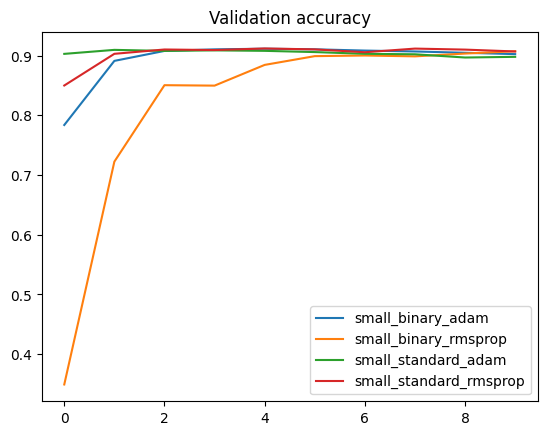

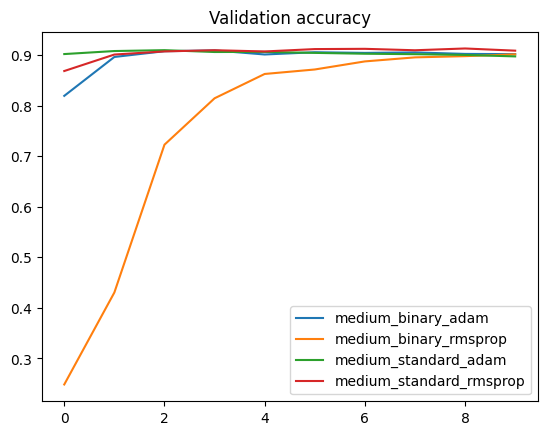

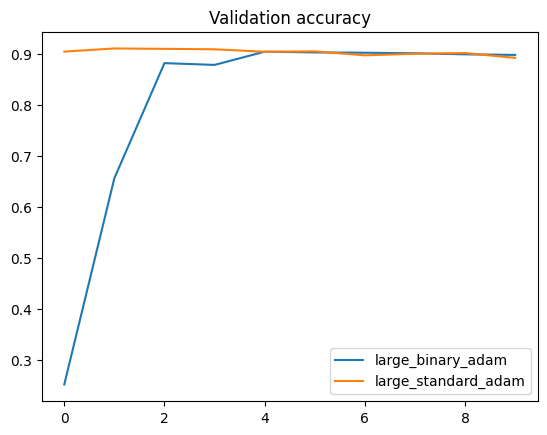

In [9]:
plot_diffrent_sizes(models)

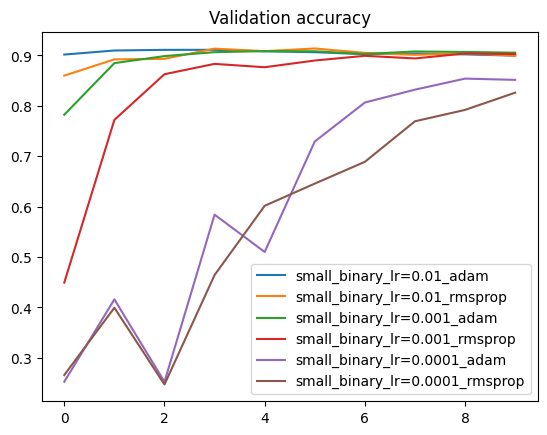

In [10]:
plot_diffrent_lr(models)

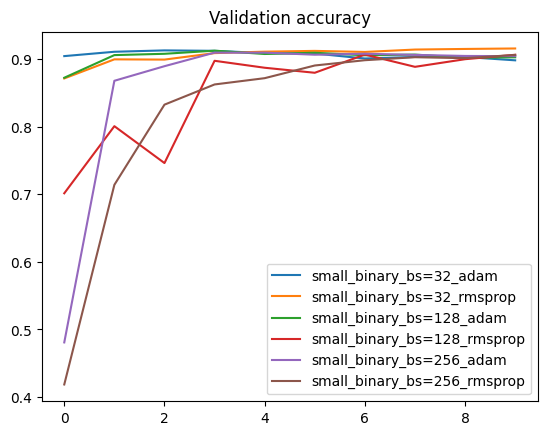

In [11]:
plot_diffrent_bs(models)

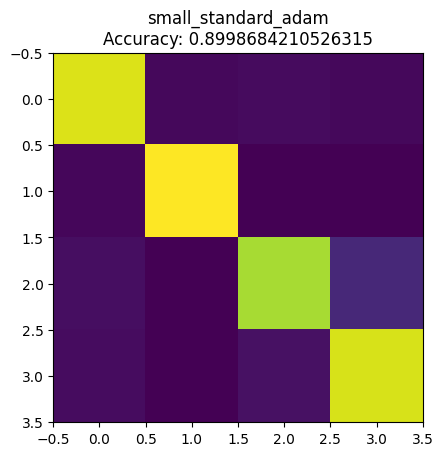

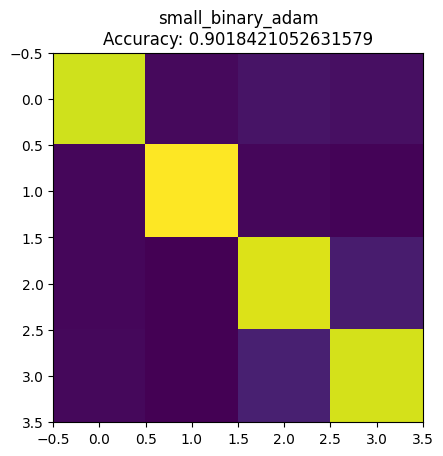

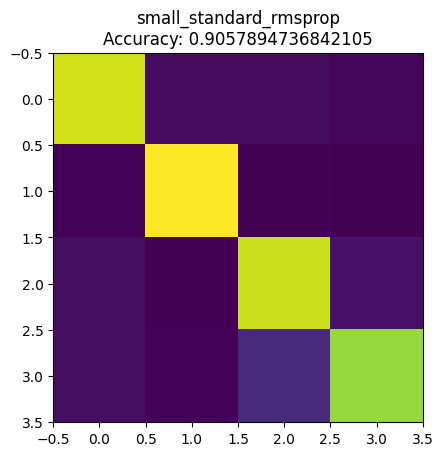

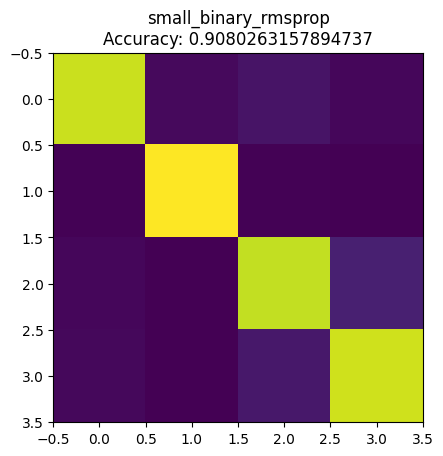

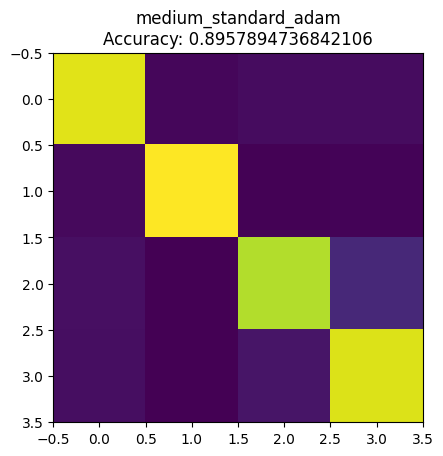

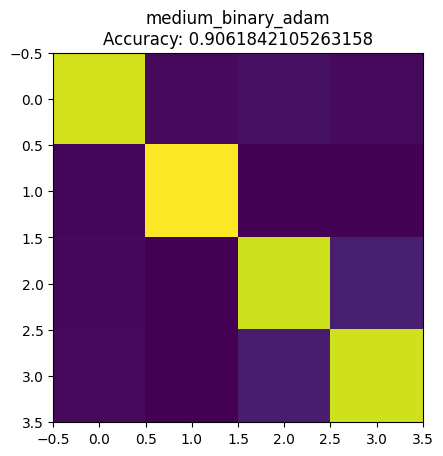

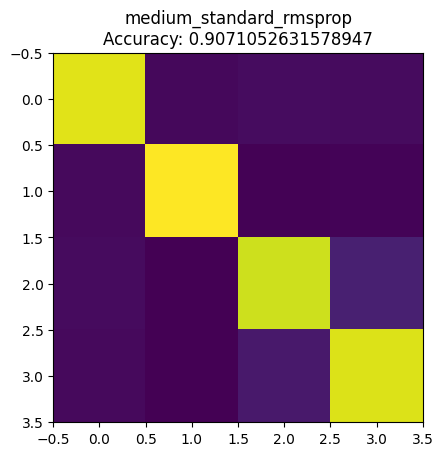

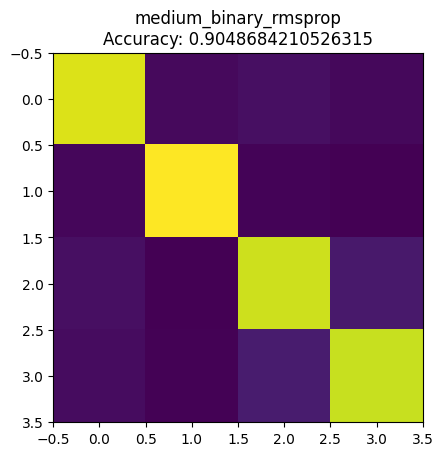

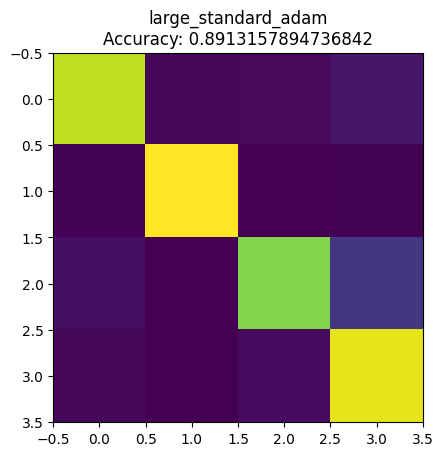

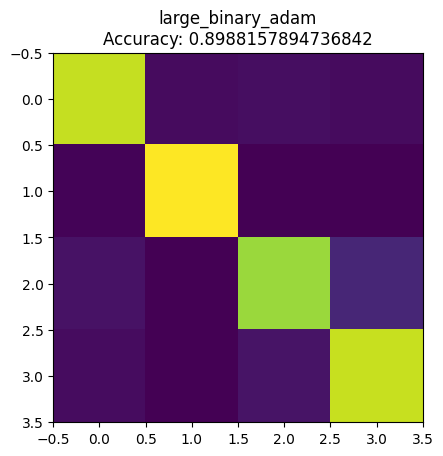

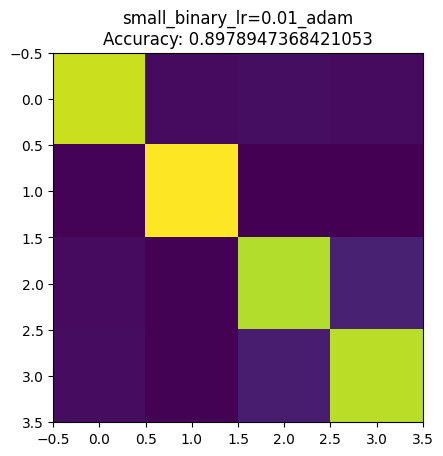

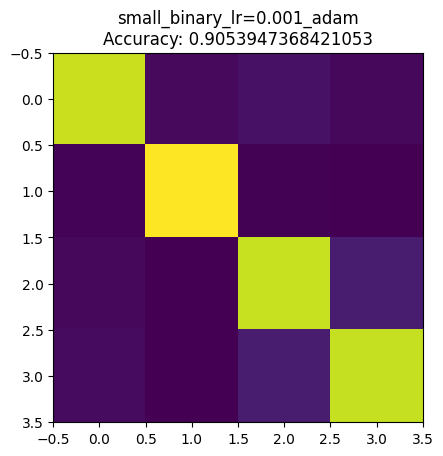

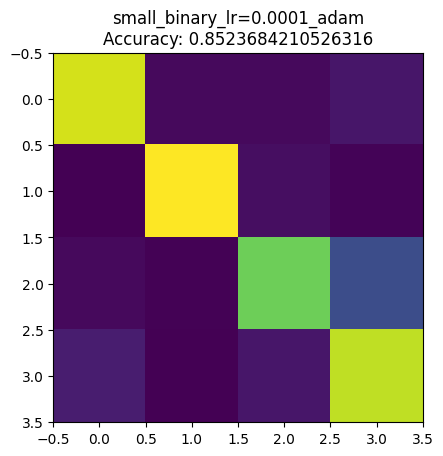

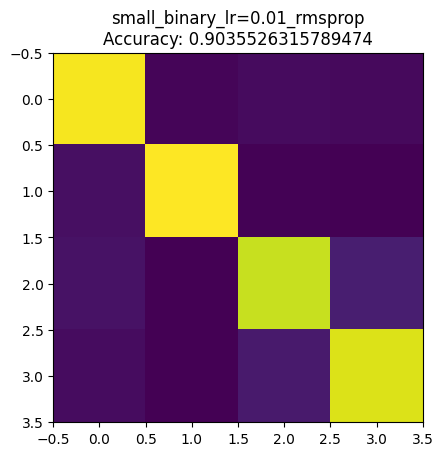

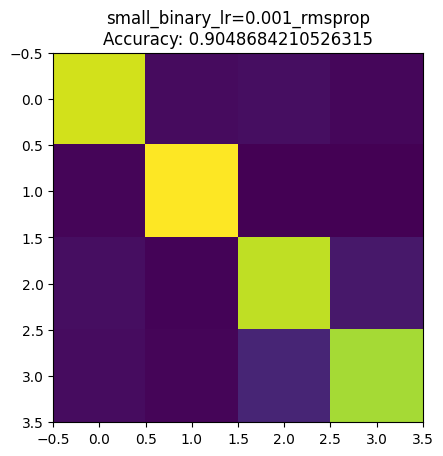

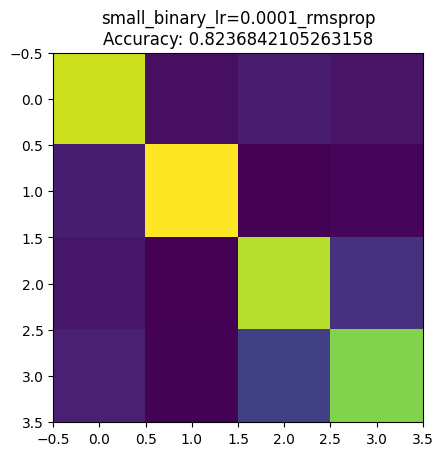

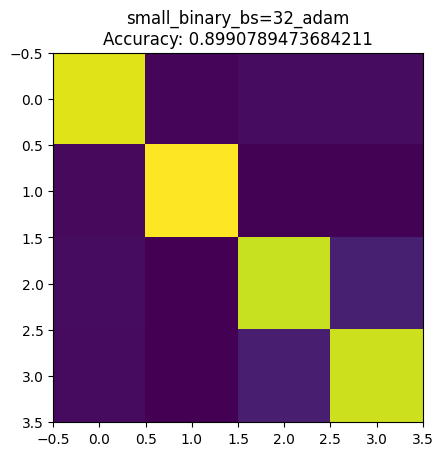

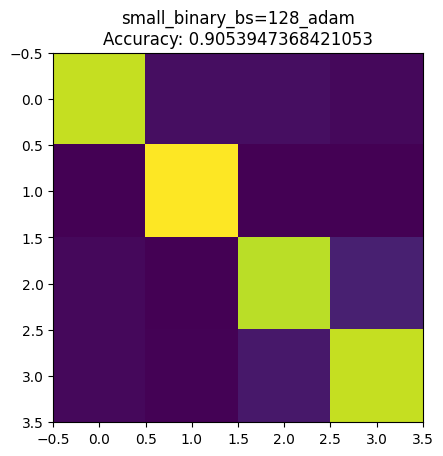

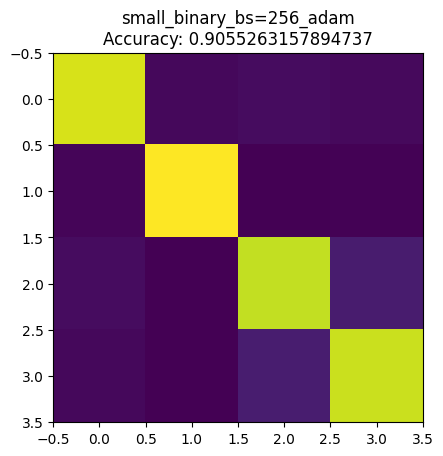

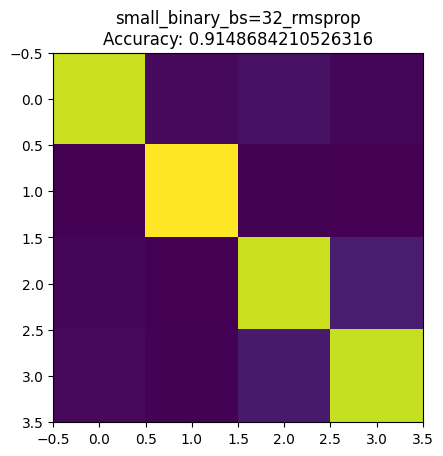

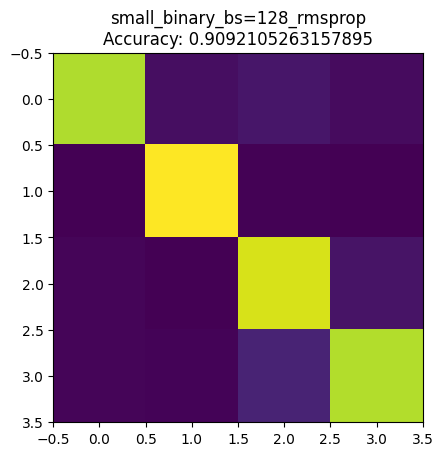

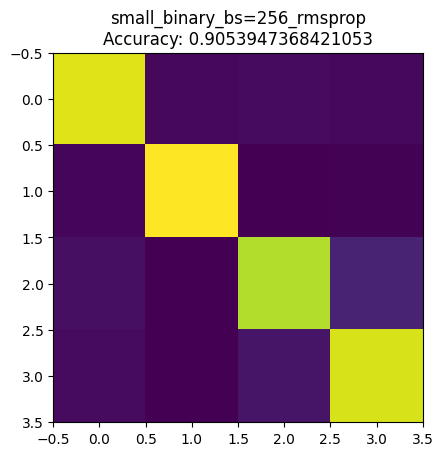

In [12]:
plot_cm(models)